Creating an Data for the NASA Challenge using random module

In [1]:
import pandas as pd
import numpy as np

# Generate a synthetic dataset
np.random.seed(0)
num_rows = 200
data = {
    'Location': np.random.choice(['Region1', 'Region2', 'Region3', 'Region4'], num_rows),
    'CO2_Emissions': np.random.uniform(100, 500, num_rows),
    'CH4_Emissions': np.random.uniform(50, 250, num_rows),
    'N2O_Emissions': np.random.uniform(10, 100, num_rows),
    'Population': np.random.randint(1000, 50000, num_rows),
    'Land_Use': np.random.choice(['Agricultural', 'Urban', 'Forested'], num_rows),
    'Date': pd.date_range(start='2023-01-01', periods=num_rows, freq='D')
}

df = pd.DataFrame(data)
df.to_csv('ghg_emissions_data.csv', index=False)


Making an Connection to MySQL and fetching the data from mysql to Vs code

In [2]:
import mysql.connector
import pandas as pd

# Load the dataset
df = pd.read_csv('ghg_emissions_data.csv')

# Connect to MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='RamanaG@253126',
    database='ghg_emissions_db'
)
cursor = conn.cursor()

# Insert data into the database
for i, row in df.iterrows():
    cursor.execute("""
        INSERT INTO emissions_data (Location, CO2_Emissions, CH4_Emissions, N2O_Emissions, Population, Land_Use, Date)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
    """, tuple(row))

conn.commit()

# Query processing
query = "SELECT * FROM emissions_data WHERE CO2_Emissions > 300;"
cursor.execute(query)
results = cursor.fetchall()

for row in results:
    print(row)

cursor.close()
conn.close()


(1, 'Region1', 371.127, 231.311, 37.9343, 6305, 'Agricultural', datetime.date(2023, 1, 1))
(3, 'Region2', 394.078, 116.629, 57.2473, 40526, 'Agricultural', datetime.date(2023, 1, 3))
(4, 'Region1', 484.875, 66.2203, 77.5536, 14195, 'Urban', datetime.date(2023, 1, 4))
(6, 'Region4', 330.463, 96.4468, 93.1743, 8762, 'Urban', datetime.date(2023, 1, 6))
(7, 'Region4', 336.817, 76.4975, 87.6087, 37076, 'Urban', datetime.date(2023, 1, 7))
(8, 'Region4', 328.901, 60.6854, 14.3821, 29675, 'Urban', datetime.date(2023, 1, 8))
(10, 'Region4', 481.1, 52.2855, 50.1522, 35183, 'Agricultural', datetime.date(2023, 1, 10))
(12, 'Region3', 438.563, 79.3893, 41.3628, 12209, 'Agricultural', datetime.date(2023, 1, 12))
(13, 'Region1', 379.792, 65.9044, 76.6088, 32504, 'Urban', datetime.date(2023, 1, 13))
(15, 'Region3', 425.519, 184.41, 66.0146, 47783, 'Agricultural', datetime.date(2023, 1, 15))
(17, 'Region1', 452.441, 134.108, 28.4431, 23657, 'Urban', datetime.date(2023, 1, 17))
(18, 'Region1', 332.509, 

After Pulling the data from MySQL..applied the data preprocessing steps with exception handling

Performed preprocessing steps like 

1)  Handling missing values
2)  Convert 'Date' column to datetime format
3)  Handle categorical variables: Encode 'Location' and 'Land_Use'
4)  Feature scaling: Apply Standard Scaling to numeric columns
5)  Detect and handle outliers using Z-score

In [3]:
import mysql.connector
from mysql.connector import Error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

def preprocess_data():
    try:
        # Connect to MySQL
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='RamanaG@253126',
            database='ghg_emissions_db'
        )
        query = "SELECT * FROM emissions_data"
        df = pd.read_sql(query, conn)
        conn.close()

    except mysql.connector.Error as err:
        print(f"Database Error: {err}")
        return
    except ConnectionError as err:
        print(f"Connection Error: {err}")
        return

    try:
        # Handling missing values
        df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill missing values in numeric columns with mean

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Handle categorical variables: Encode 'Location' and 'Land_Use'
        label_encoders = {}
        for column in ['Location', 'Land_Use']:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le

        # Feature scaling: Apply Standard Scaling to numeric columns
        scaler = StandardScaler()
        numeric_columns = ['CO2_Emissions', 'CH4_Emissions', 'N2O_Emissions', 'Population']
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

        # Detect and handle outliers using Z-score
        z_scores = stats.zscore(df[numeric_columns])
        abs_z_scores = np.abs(z_scores)
        df = df[(abs_z_scores < 3).all(axis=1)]  # Remove rows with Z-score > 3 (outliers)

        print(df.head())

    except pd.errors.EmptyDataError as err:
        print(f"Data Error: {err}")
    except pd.errors.ParserError as err:
        print(f"Parsing Error: {err}")
    except ValueError as err:
        print(f"Value Error: {err}")
    except TypeError as err:
        print(f"Type Error: {err}")
    except Exception as err:
        print(f"An unexpected error occurred: {err}")

    finally:
        try:
            if conn.is_connected():
                conn.close()
        except NameError:
            # Conn was never initialized
            pass
        except mysql.connector.Error as err:
            print(f"Error closing connection: {err}")

preprocess_data()


   id  Location  CO2_Emissions  CH4_Emissions  N2O_Emissions  Population  \
0   1         0       0.548876       1.432767      -0.638549   -1.341811   
1   2         3      -0.859253       0.981068      -0.422868    0.446879   
2   3         1       0.746995      -0.521871       0.100161    1.034014   
3   4         0       1.530778      -1.381036       0.876864   -0.794040   
4   5         3      -0.932645      -0.269296      -0.558937    1.681064   

   Land_Use       Date  
0         0 2023-01-01  
1         0 2023-01-02  
2         0 2023-01-03  
3         2 2023-01-04  
4         0 2023-01-05  


C:\Users\pc\AppData\Local\Temp\ipykernel_22084\4001139890.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [10]:
df

,Location,CO2_Emissions,CH4_Emissions,N2O_Emissions,Population,Land_Use,Date
0,Region1,371.126615,231.311100,37.934274,6305,Agricultural,2023-01-01
1,Region4,208.003189,204.809467,43.573138,32069,Agricultural,2023-01-02
2,Region2,394.077609,116.629030,57.247340,40526,Agricultural,2023-01-03
3,Region1,484.875418,66.220278,77.553552,14195,Urban,2023-01-04
4,Region4,199.501257,131.448234,40.015672,49846,Agricultural,2023-01-05
...,...,...,...,...,...,...,...
195,Region1,189.726812,104.330554,42.858989,22511,Urban,2023-07-15
196,Region1,139.137794,141.088830,27.151022,28532,Agricultural,2023-07-16
197,Region2,444.876607,130.342707,11.721061,47368,Forested,2023-07-17
198,Region3,489.167796,99.682693,56.633483,22227,Agricultural,2023-07-18


Checking whether all the preprocessing steps worked perfectly or not

In [9]:
df.isnull().sum()

Location         0
CO2_Emissions    0
CH4_Emissions    0
N2O_Emissions    0
Population       0
Land_Use         0
Date             0
dtype: int64

In [14]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

Now Again making a connection to MySQL to send back the preprocessed data into a new table

In [16]:
import pandas as pd
import mysql.connector
import os

# Assuming df is your preprocessed DataFrame

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="RamanaG@253126",
    database="ghg_emissions_db"
)
cursor = conn.cursor()

# SQL query to insert data into the existing table
insert_query = """
    INSERT INTO preprocessed_emissions_data1 
    (Date, Location, Land_Use, CO2_Emissions, CH4_Emissions, N2O_Emissions, Population)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
"""

# Loop through the preprocessed DataFrame and insert each row into MySQL
for index, row in df.iterrows():
    # Convert datetime to string format for MySQL if necessary
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S') if not pd.isnull(row['Date']) else None

    cursor.execute(insert_query, (
        date, 
        row['Location'], 
        row['Land_Use'], 
        row['CO2_Emissions'], 
        row['CH4_Emissions'], 
        row['N2O_Emissions'], 
        row['Population']
    ))

# Commit changes
conn.commit()

# Close connection
cursor.close()
conn.close()

print("Preprocessed data has been inserted into the MySQL table successfully.")


Preprocessed data has been inserted into the MySQL table successfully.


In [17]:
df.to_csv('ghg_preprocessed_data.csv', index=False)

PHASE 2 DATA VISUALIZATION

C:\Users\pc\AppData\Local\Temp\ipykernel_22084\2597509013.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Location', y='CO2_Emissions', estimator='mean', ci=None)


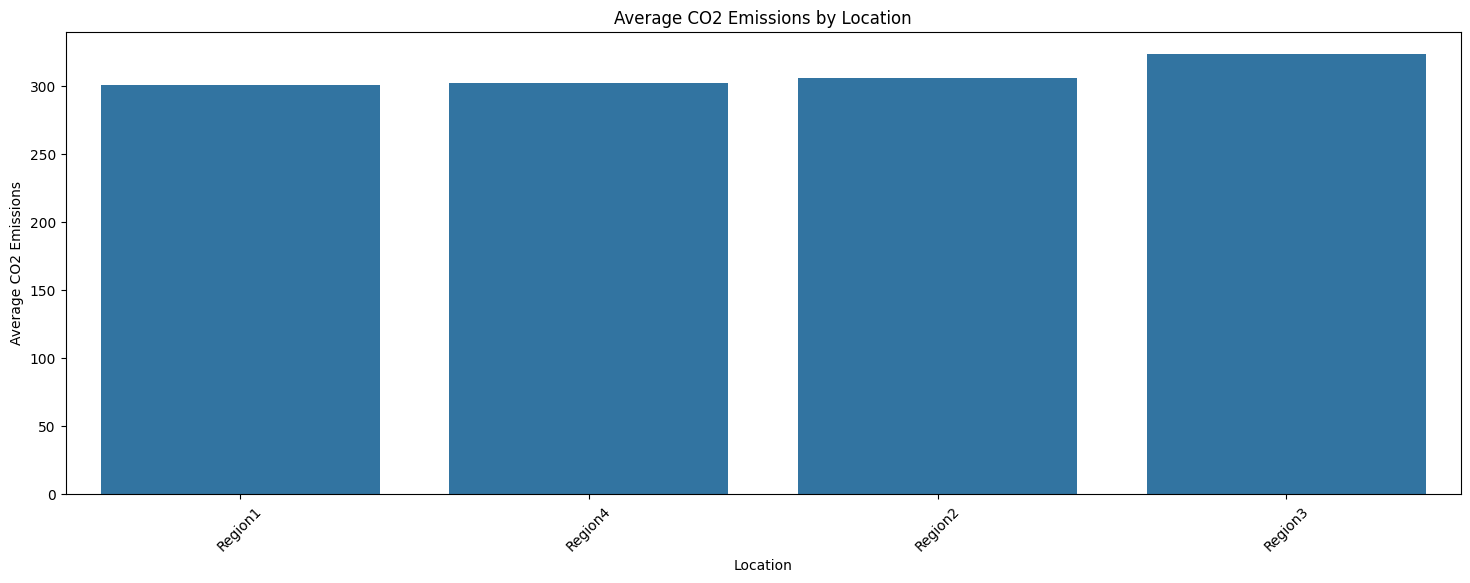

In [19]:
# Plot

df  = pd.read_csv("ghg_preprocessed_data.csv")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 6))
sns.barplot(data=df, x='Location', y='CO2_Emissions', estimator='mean', ci=None)
plt.title('Average CO2 Emissions by Location')
plt.xlabel('Location')
plt.ylabel('Average CO2 Emissions')
plt.xticks(rotation=45)
plt.show()

Pairplot

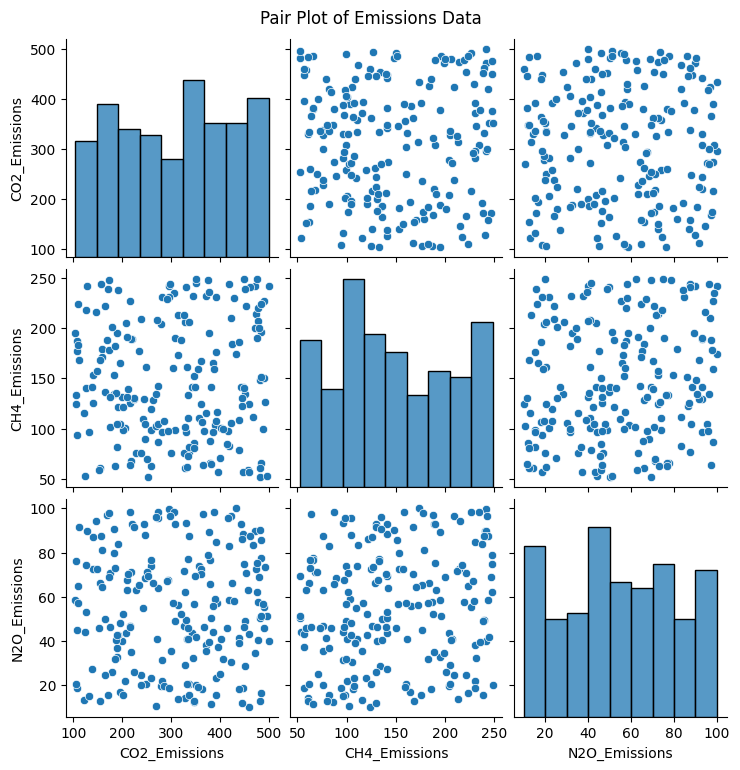

In [21]:
sns.pairplot(df[['CO2_Emissions', 'CH4_Emissions', 'N2O_Emissions', 'Location']])
plt.suptitle('Pair Plot of Emissions Data', y=1.02)
plt.show()


Boxplot

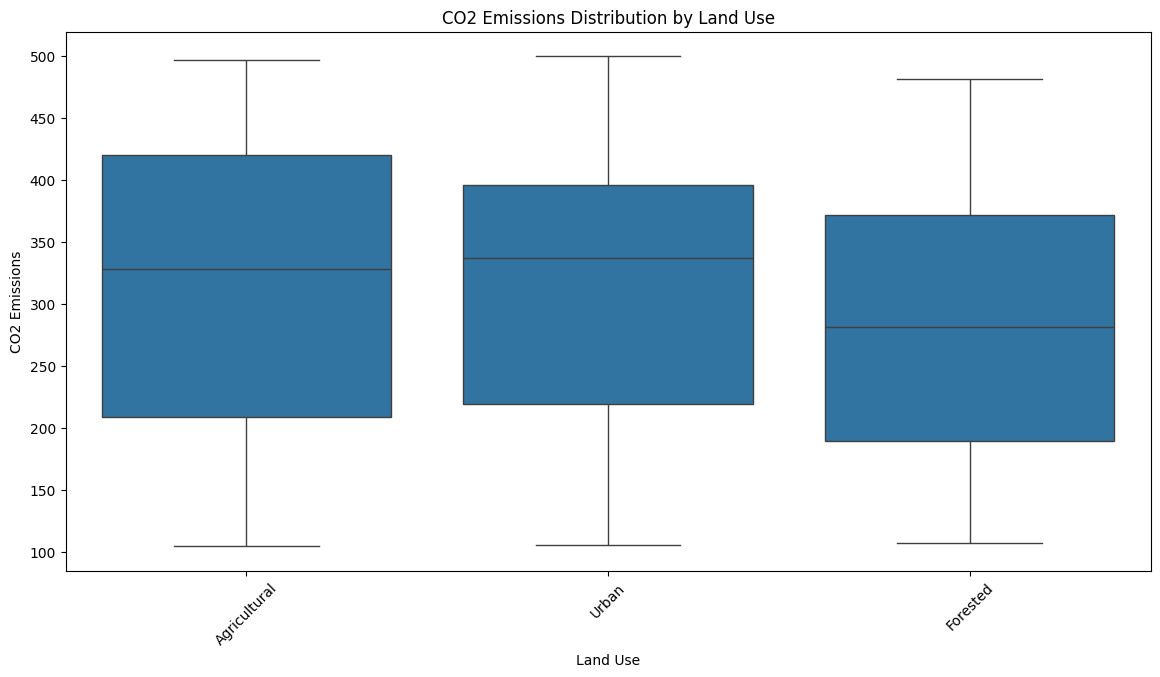

In [22]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Land_Use', y='CO2_Emissions')
plt.title('CO2 Emissions Distribution by Land Use')
plt.xlabel('Land Use')
plt.ylabel('CO2 Emissions')
plt.xticks(rotation=45)
plt.show()


Heatmap by Correlation matrix

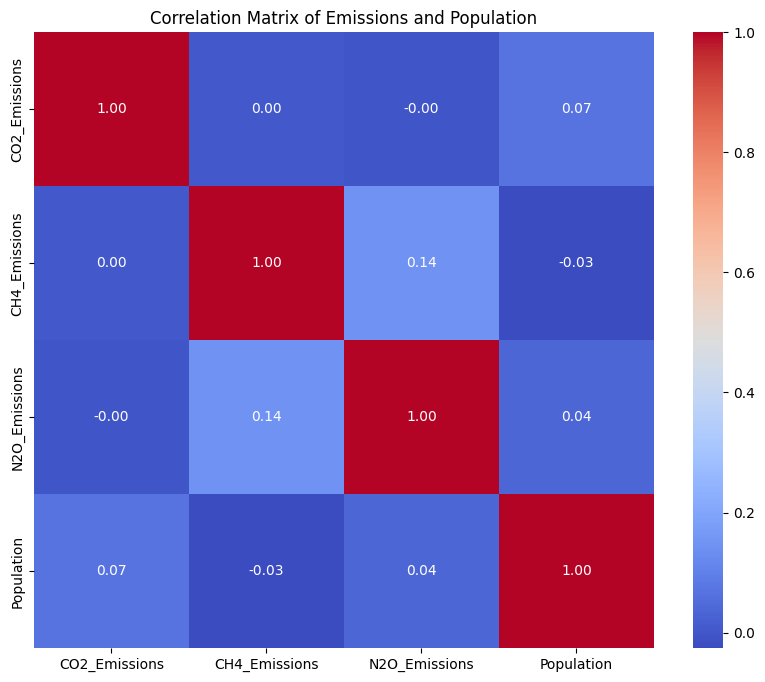

In [23]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['CO2_Emissions', 'CH4_Emissions', 'N2O_Emissions', 'Population']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Emissions and Population')
plt.show()
